In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from logger import get_logger
_logs = get_logger(__name__)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

c:\Users\Test\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\Test\AppData\Local\Temp\ipykernel_23468\1500862777.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be 

In [3]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index()

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777702 entries, 0 to 2777701
Data columns (total 15 columns):
 #   Column           Dtype         
---  ------           -----         
 0   ticker           object        
 1   Date             datetime64[ns]
 2   Open             float64       
 3   High             float64       
 4   Low              float64       
 5   Close            float64       
 6   Adj Close        float64       
 7   Volume           int64         
 8   sector           object        
 9   subsector        object        
 10  year             int32         
 11  Close_lag_1      float64       
 12  returns          float64       
 13  positive_return  int32         
 14  target           float64       
dtypes: datetime64[ns](1), float64(8), int32(2), int64(1), object(3)
memory usage: 296.7+ MB


# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [8]:
df.sample(n = 5)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag_1,returns,positive_return,target
1105010,UDR,2006-01-30,25.559999,25.559999,25.450001,25.520000,11.146977,651200,Real Estate,Multi-Family Residential REITs,2006,25.50000,0.000784,1,0.0
1585574,PEG,2019-06-07,60.709999,61.209999,59.900002,60.009998,50.077953,1872800,Utilities,Electric Utilities,2019,60.32000,-0.005139,0,0.0
2033408,HII,2024-02-28,290.000000,292.820007,289.850006,291.850006,289.005371,257800,Industrials,Aerospace & Defense,2024,289.48999,0.008152,1,0.0
2180392,VRTX,2009-10-15,34.169998,35.490002,34.080002,35.259998,35.259998,2532000,Health Care,Biotechnology,2009,34.32000,0.027389,1,0.0
204374,LKQ,2007-08-28,7.752500,8.117500,7.425000,7.487500,7.008042,2420000,Consumer Discretionary,Distributors,2007,7.91500,-0.054011,0,1.0


In [9]:
# select_tickers = df['ticker'].unique().tolist()[0:9]
select_tickers = ['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']
select_tickers

['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']

In [10]:
idx = df['ticker'].isin(select_tickers)
small_df = df[idx]
simple_sample_dt = small_df.sample(frac = 0.1)
simple_sample_dt.shape, small_df.shape

((5506, 15), (55055, 15))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

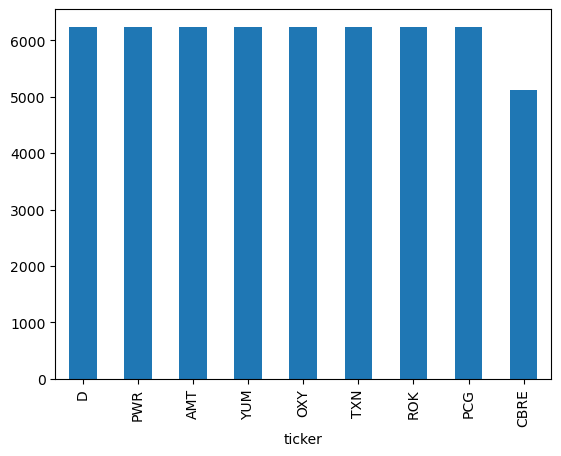

In [11]:
small_df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

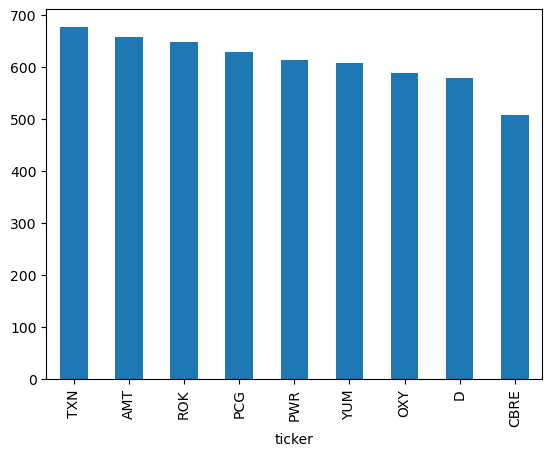

In [12]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

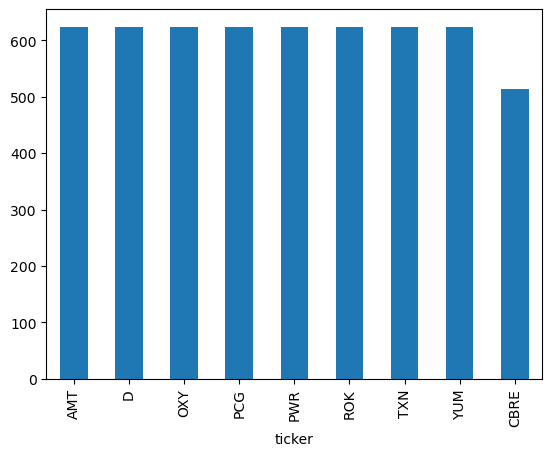

In [16]:
strat_sample_dt = small_df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

C:\Users\Test\AppData\Local\Temp\ipykernel_23468\2932236319.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd_dt = (dd_dt


<Axes: xlabel='ticker'>

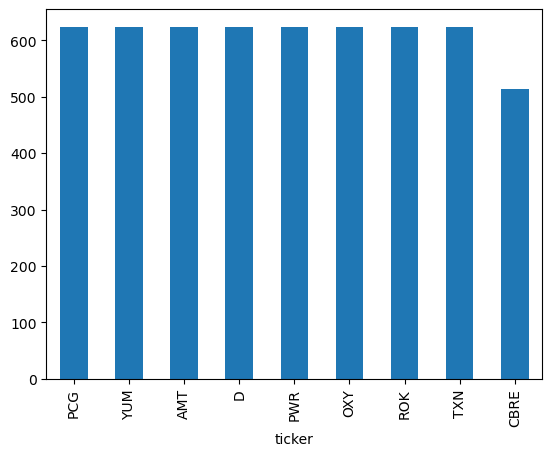

In [17]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd_dt = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd_dt[strat_sample_dd_dt['ticker'].isin(select_tickers)]['ticker'].value_counts().plot(kind='bar')